In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install numpy pandas scikit-learn torch transformers seaborn matplotlib tqdm

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, label_binarize
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm import tqdm

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

Usando dispositivo: cuda


In [11]:
df = pd.read_csv('/content/drive/MyDrive/9categ/9cat_test_dataset.csv')
label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['label'])
df.head()

,text,label,encoded_label
0,El que llegireu a continuació és una d’aquelle...,ciencia,0
1,Uno de los principales problemas que provocan ...,ciencia,0
2,La primavera de este año deja dos eclipses. El...,ciencia,0
3,En un discret racó del laboratori d’oncologia ...,ciencia,0
4,"La lluna, l’únic satèl·lit natural de la Terra...",ciencia,0


In [12]:
model_name = 'dccuchile/bert-base-spanish-wwm-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
num_labels = len(df['encoded_label'].unique())
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model.to(device)
model.eval()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['classifier.weight', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [13]:
def predict_label(text):
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_label_id = torch.argmax(logits, dim=1).item()
        predicted_label = label_encoder.inverse_transform([predicted_label_id])[0]
        probabilities = torch.nn.functional.softmax(logits, dim=1)[0].cpu().numpy()
        return predicted_label, probabilities


In [14]:
tqdm.pandas()
results = df['text'].progress_apply(lambda x: predict_label(x))
df['predicted_label'] = results.progress_apply(lambda x: x[0])
probabilities = results.progress_apply(lambda x: x[1]).tolist()

100%|██████████| 1800/1800 [00:00<00:00, 449229.28it/s]


In [15]:
accuracy = accuracy_score(df['label'], df['predicted_label'])
precision = precision_score(df['label'], df['predicted_label'], average='weighted')
recall = recall_score(df['label'], df['predicted_label'], average='weighted')
f1 = f1_score(df['label'], df['predicted_label'], average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.09777777777777778
Precision: 0.021378715071197152
Recall: 0.09777777777777778
F1 Score: 0.026859513004919518


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
probabilities_array = np.array(probabilities)
roc_auc = roc_auc_score(df['encoded_label'], probabilities_array, multi_class='ovr')
print(f"AUC (One-vs-Rest): {roc_auc}")

AUC (One-vs-Rest): 0.4409739583333334


In [17]:
df.to_csv('/content/drive/MyDrive/9categ/9cat_test_dataset_with_predictions_bert_untrained.csv', index=False)

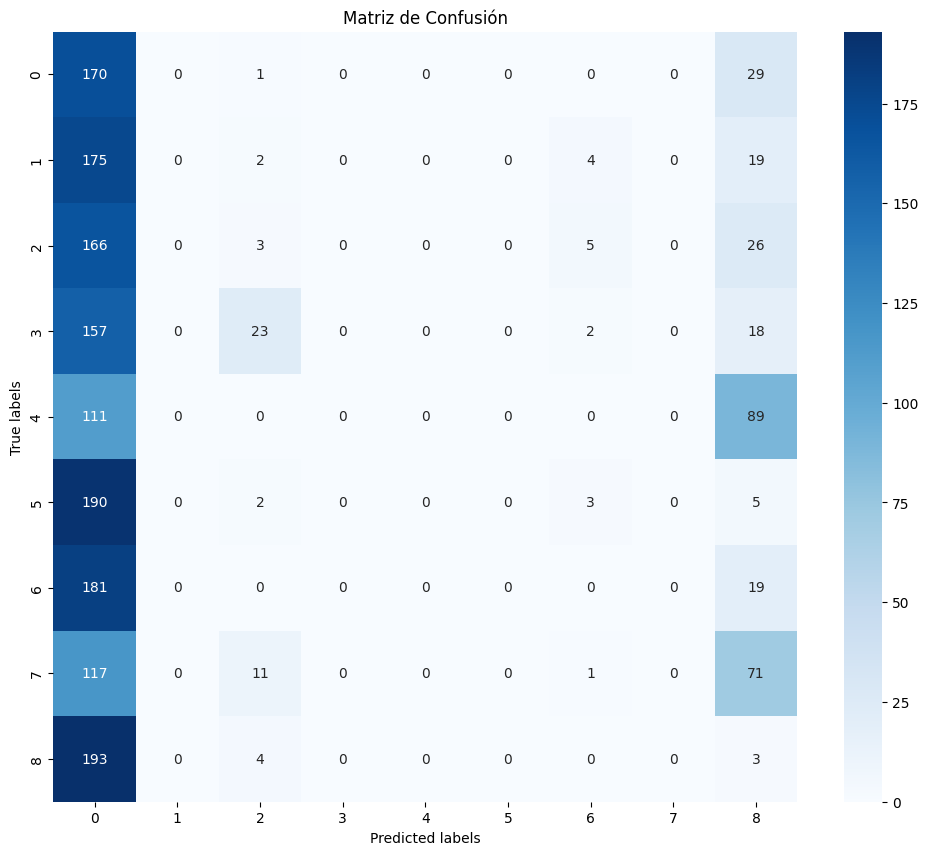

In [18]:
plt.figure(figsize=(12, 10))
cm = confusion_matrix(df["label"], df['predicted_label'])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Matriz de Confusión")
plt.show()

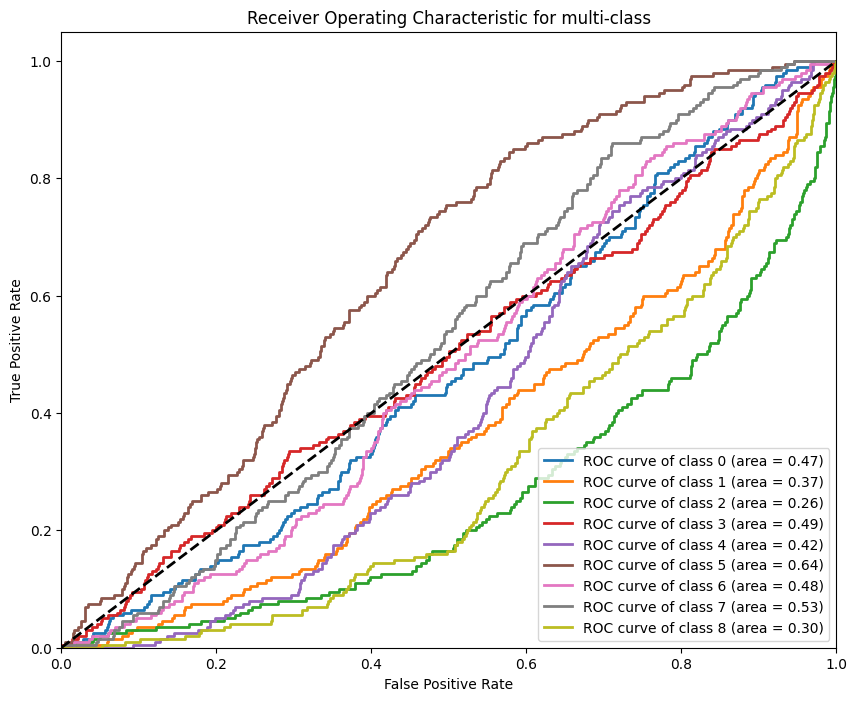

In [19]:
y_bin = label_binarize(df['encoded_label'], classes=[*range(len(label_encoder.classes_))])

n_classes = y_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], probabilities_array[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class')
plt.legend(loc="lower right")
plt.show()
